# Homework 2
### ASTR-324, Spring 2017, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s17/astr-324-s17


## Problem 1

Using astroML figure 3.12 as a template, see

http://www.astroml.org/book_figures/chapter3/fig_cauchy_median_mean.html

add another panel, similar to the top panel, that will plot and compare 
results for standard deviation and $\sigma_G$. 


## Problem 2

Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the
true distribution. 

## Problem 3

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 

## Problem 4
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Comment.  

<br>
# Solutions

### Some useful definitions and functions

In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from scipy import optimize
from scipy.stats import cauchy, norm, poisson
from astroML import stats as astroMLstats

This astroML function adjusts matplotlib settings for a uniform feel in the 
textbook. Note that with `usetex=True`, fonts are rendered with $\LaTeX$. This 
may result in an error if $\LaTeX$ is not installed on your system.  In that 
case, you can set usetex to `False`.

In [2]:
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

## Problem 1

In [3]:
# Create Data Set
np.random.seed(6)
mu = 0
gamma = 2

xi = cauchy(mu, gamma).rvs(100)
Nrange = np.arange(1, len(xi) + 1)

In [4]:
#Calculate Standard Deviation and Sigma G

def robust_stdev(x):
    """
    Input:
        x: Input Sample
        
    Output: Standard deviation for the input sample
    """
    
    if len(x) == 1:
        return np.std(x)
    
    dim = len(x)
    stdev_lst = []
    
    for num in range(dim):
        new_stdev = np.std(x[:num])
        stdev_lst.append(new_stdev)
        
    return stdev_lst

def robust_sigmaG(x):
    """
    Input:
        x: Input Sample
        
    Output: Sigma G for the input sample
    """

    if len(x) == 1:
        return astroMLstats.sigmaG(x)
    
    dim = len(x)
    sigmaG_lst = []
    
    for num in range(1,dim + 1):
        new_sigmaG = astroMLstats.sigmaG(x[:num])
        sigmaG_lst.append(new_sigmaG)
        
    return sigmaG_lst
    
stdev = robust_stdev(xi)
sigmaG = robust_sigmaG(xi)

//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
//anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# Previous plots from Jake VanderPlas

def robust_mean_mixture(x):
    """Compute the mean via a mixture of two Gaussians

    One Gaussian accounts for outliers, and one Gaussian accounts  for
    the true distribution.  This cannot be computed analytically, so
    it uses scipy's function optimization
    """
    if len(x) == 1:
        return x

    x = x.ravel()

    mu_bg = np.mean(x)
    sig_bg = 3 * np.std(x)

    likelihood = lambda v: -np.sum(np.log(norm.pdf(x, v[0], v[1])
                                          + norm.pdf(x, mu_bg, sig_bg)))

    v0 = np.array([0, 30])

    v_best = optimize.fmin(likelihood, v0, disp=False)

    return v_best[0]

def robust_mean_iterated(x, sigma_cut=3):
    """Compute the robust mean iteratively

    After computing the mean, points further than 3 sigma from the mean
    are removed and the result is repeated until convergence.
    """
    flag = np.ones(x.shape, dtype=bool)
    n_to_keep = x.size

    while True:
        xf = x[flag]
        mu = xf.mean()
        sig = xf.std()
        if len(xf) == 1:
            break

        x_sig = abs((x - mu) / sig)

        too_far = (x_sig > sigma_cut)
        flag[too_far] = False
        n_flag = flag.sum()

        if n_flag == n_to_keep:
            break
        else:
            n_to_keep = n_flag

    return mu

mean = [np.mean(xi[:N]) for N in Nrange]
median = [np.median(xi[:N]) for N in Nrange]
mean_mixture = [robust_mean_mixture(xi[:N]) for N in Nrange]
mean_iter = [robust_mean_iterated(xi[:N]) for N in Nrange]

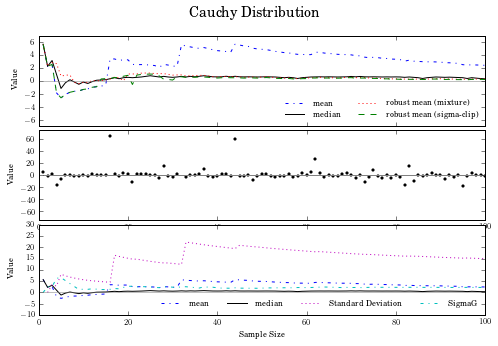

In [6]:
# Plot of 3 panels

fig = plt.figure(figsize=(8, 5))
fig.subplots_adjust(hspace=0.05)
fig.suptitle('Cauchy Distribution', fontsize=14, fontweight='bold')

# first plot the mean
ax = fig.add_subplot(311)
ax.plot(Nrange, mean, '-.b', label='mean')
ax.plot(Nrange, median, '-k', label='median')
ax.plot(Nrange, mean_mixture, ':r', label='robust mean (mixture)')
ax.plot(Nrange, mean_iter, '--g', label='robust mean (sigma-clip)')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)

ax.set_xlim(0, 100)
ax.set_ylim(-7, 7)
ax.legend(loc=4, ncol=2, frameon=False)
ax.set_ylabel('Value')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# now plot the median
ax = fig.add_subplot(312)
ax.scatter(Nrange, xi, lw=0, s=10, c='k')
ax.plot(Nrange, 0 * Nrange, '-', c='gray')
ax.set_xlim(0, 100)
ax.set_ylim(-75, 75)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')

# Plot of standard deviation and sigmaG

ax = fig.add_subplot(313)
ax.plot(Nrange, mean, '-.b', label='mean')
ax.plot(Nrange, median, '-k', label='median')
ax.plot(Nrange, stdev, ':m', label='Standard Deviation')
ax.plot(Nrange, sigmaG, '-.c', label='SigmaG')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')
ax.set_xlim(0, 100)
ax.set_ylim(-10, 30)
ax.legend(loc=4, ncol=4, frameon=False)

plt.show()

## Problem 2

In [7]:
# Freedman-Diaconis rule
def FD(dist, size):
    """
    Input:
        dist: Distribution sample
        size: Number of entries in the sample
    
    Output:
        bin_size: Freedman-diaconis rule bin width
    """
    
    q25 = np.percentile(dist, 25)
    q75 = np.percentile(dist, 75)
    IQR = q75 - q25
    bin_size = (2*IQR)/(np.cbrt(size))
    return bin_size

# Scott's rule
def Scott(dist, size):
    """
    Input:
        dist: Distribution sample
        size: Number of entries in the sample
    
    Output:
        bin_size: Scott's rule bin width
    """
    
    q25 = np.percentile(dist, 25)
    q75 = np.percentile(dist, 75)
    sigmaG = 0.7413 * (q75-q25)
    bin_size = 3.5 * sigmaG / np.cbrt(size)
    return bin_size

In [8]:
k = 10000
M = 10000
mu = 1.0
sigma = 0.2

xGrid = np.linspace(0, 2, 10000)
dist = norm(mu, sigma).rvs(M)
Err = 0.7413 * (np.percentile(dist, 75) - np.percentile(dist, 25))

bin_size = FD(dist, k)
num_bin = round((max(dist)-min(dist))/bin_size)

# Create the gaussian fit
gauss = norm(mu, sigma/np.sqrt(1)).pdf(xGrid)

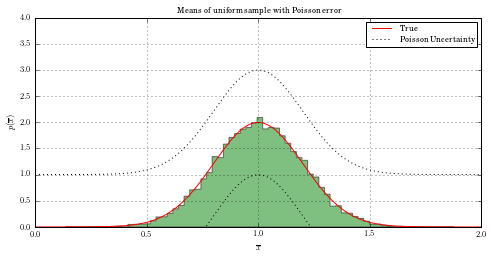

In [9]:
# Plot

fig, ax = plt.subplots(figsize=(8, 3.75))
ax.hist(dist, bins=num_bin, facecolor='green', 
        histtype='stepfilled', alpha=0.5, normed=True)
ax.plot(xGrid, gauss, ls='-', c='red', label='True')
#ax.plot(xGrid, gauss + Err, ls=':', c='k', label='Poisson Uncertainty')
#ax.plot(xGrid, gauss - Err, ls=':', c='k')
plt.error
plt.xlim(0.0, 2.0)
plt.ylim(0.0, max(gauss) + 2*Err)
plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
plt.title('Means of uniform sample with Poisson error')
plt.legend()
plt.grid(True)
plt.show()

## Problem 3

In [10]:
"""
Do the same for a Cauchy distribution with the 
same $\mu$ and $\gamma=0.2$.
"""

mu = 1.0
gamma = 0.2
dist = cauchy(mu, gamma)
r = dist.rvs(k)

bin_size = FD(r, k)
num_bin = round((max(r) - min(r))/bin_size)
sigmaG = 1.483 * gamma

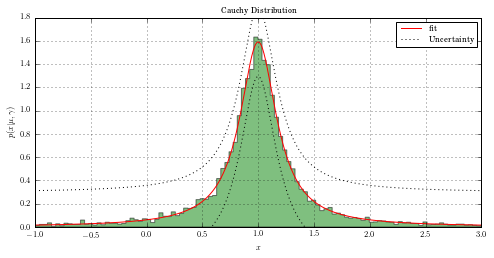

In [11]:
xRange = np.linspace(-1, 10, max(r)-min(r))

fig, ax = plt.subplots(figsize=(8, 3.75))
ax.hist(r, bins=num_bin, facecolor='green', 
        histtype='stepfilled', alpha=0.5, normed=True)
ax.plot(xRange, dist.pdf(xRange), color='red', 
        label="fit")
ax.plot(xRange, dist.pdf(xRange)+sigmaG, color='black', 
        ls=':', label="Uncertainty")
ax.plot(xRange, dist.pdf(xRange)-sigmaG, color='black', ls=':')
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\gamma)$')
plt.title('Cauchy Distribution')
plt.legend()
plt.grid(True)
plt.xlim(-1, 3)
plt.ylim(0, 1.8)
plt.show()

## Problem 4

In [12]:
# Repeat problem 2
k = 10000
M = 10000
mu = 1.0
sigma = 0.2
dist_gauss = norm(mu, sigma).rvs(M)

# Cuauchy distribution

mu_2 = 2.0
gamma = 0.5
dist = cauchy(mu_2, gamma)
r = dist.rvs(k)

In [13]:
# Add cauchy and Gaussian distributions
gauss_cauchy = np.concatenate((dist_gauss, r), axis=0) 
cauchy_fd = FD(gauss_cauchy, 10000)
cauchy_Scott = Scott(gauss_cauchy, 10000)

# Calculate the number of bins with width of distrbution and bin width
num_bins_fd = round(max((gauss_cauchy) - min(gauss_cauchy))/cauchy_fd)
num_bins_Sc = round(max((gauss_cauchy) - min(gauss_cauchy))/cauchy_Scott)

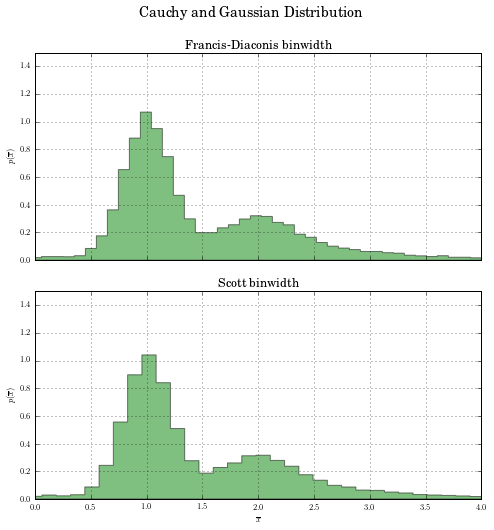

In [14]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.15)
fig.suptitle('Cauchy and Gaussian Distribution', fontsize=14, fontweight='bold')

# Plot distribution with Francis-Diaconis binwidth
ax = fig.add_subplot(211)
ax.hist(gauss_cauchy, bins=num_bins_fd, facecolor='green', 
        histtype='stepfilled', alpha=0.5, normed=True)
plt.xlim(0, 4)
plt.ylim(0, 1.5)
plt.title('Francis-Diaconis binwidth', fontsize=12)
plt.ylabel(r'$p(\overline{x})$')
plt.grid(True)
ax.xaxis.set_major_formatter(plt.NullFormatter())

# Plot distribution with Scott's bindwidth
ax = fig.add_subplot(212)
ax.hist(gauss_cauchy, bins=num_bins_Sc, facecolor='green', 
        histtype='stepfilled', alpha=0.5, normed=True)
plt.xlim(0, 4)
plt.ylim(0, 1.5)
plt.title('Scott binwidth', fontsize=12)
plt.xlabel('$\overline{x}$')
plt.ylabel(r'$p(\overline{x})$')
plt.grid(True)

plt.show()